In [6]:
#----6.8.2022--
#use smore to get super-resolution image from a low-res image
#psnr, ssim, fft in decibels
#compare the whole volume

#what is mse(mean square error)? do we use it?

#ERROR: we cannot use 03-skip-03 because the smore image has different dimensions than original image
#cropping or resizing the smore image doesn't work and messes up the ssim and psnr values
#so we are using -4-skip-00, which is a multiple of 256 (the size of original image)


In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import math
from resize.scipy import resize
import copy
from tqdm import tqdm

import tensorflow as tf
import cv2
from skimage.metrics import structural_similarity as ssim
import skimage

In [9]:
#import my own functions
from utils.myutils import *

In [10]:
#function that takes a np fourier transformation array, computes the magnitude, and returns a np array of decibels
def fft_to_db(x_fft,epsilon=1e-8):
    x_mag = np.zeros(x_fft.shape)
    
    #finding the magnitude from fft, store in x_mag
    for m,f in zip(x_mag, x_fft):# a row in x_fft
        for i in range(len(m)): # each pixel in row
            m[i] = np.abs(f[i])  
            
    #decibels
    x_db = np.zeros(x_mag.shape)
    for m, d in zip(x_mag, x_db):
        for i in range(len(d)):
            d[i] = 20*math.log10(m[i]+epsilon)
    
    return x_db

In [11]:
data_dir = Path("/iacl/pg22/sam/data/OASIS3")
ash_dir = Path("/iacl/pg22/ashley/data/results/04-skip-00/sub-OAS30167_ses-d0111_T1w")


In [12]:
!ls /iacl/pg22/sam/data/OASIS3/OASIS3_LR"/"04-skip-00/

sub-OAS30003_ses-d0558_run-01_T1w.nii.gz
sub-OAS30014_ses-d0196_run-01_T1w.nii.gz
sub-OAS30015_ses-d0116_run-01_T1w.nii.gz
sub-OAS30017_ses-d0054_run-01_T1w.nii.gz
sub-OAS30026_ses-d0048_T1w.nii.gz
sub-OAS30031_ses-d0427_run-01_T1w.nii.gz
sub-OAS30036_ses-d0059_T1w.nii.gz
sub-OAS30051_ses-d0200_run-01_T1w.nii.gz
sub-OAS30063_ses-d0160_run-01_T1w.nii.gz
sub-OAS30070_ses-d0070_T1w.nii.gz
sub-OAS30090_ses-d0118_T1w.nii.gz
sub-OAS30091_ses-d0092_run-01_T1w.nii.gz
sub-OAS30111_ses-d0385_run-01_T1w.nii.gz
sub-OAS30124_ses-d0046_run-01_T1w.nii.gz
sub-OAS30126_ses-d1105_run-01_T1w.nii.gz
sub-OAS30130_ses-d0025_run-01_T1w.nii.gz
sub-OAS30133_ses-d0505_T1w.nii.gz
sub-OAS30142_ses-d0075_run-01_T1w.nii.gz
sub-OAS30145_ses-d3506_run-01_T1w.nii.gz
sub-OAS30149_ses-d0051_T1w.nii.gz
sub-OAS30165_ses-d0563_run-01_T1w.nii.gz
sub-OAS30167_ses-d0111_T1w.nii.gz
sub-OAS30173_ses-d1188_run-01_T1w.nii.gz
sub-OAS30182_ses-d0094_T1w.nii.gz
sub-OAS30184_ses-d0169_run-01_T1w.nii.gz
sub-OAS30202_ses-d0175_run-01_T

In [13]:
#high resolution directory
hr_img_path = data_dir/"OASIS3_iso"/"sub-OAS30167_ses-d0111_T1w.nii.gz"
obj1 = nib.load(hr_img_path)
hr_img = obj1.get_fdata(dtype=np.float32)

In [14]:
#low resolution directory
lr_img_path = data_dir/"OASIS3_LR"/"04-skip-00"/"sub-OAS30167_ses-d0111_T1w.nii.gz"
obj2 = nib.load(lr_img_path)
lr_img = obj2.get_fdata(dtype=np.float32)

In [15]:
#smore directory
sm_img_path = ash_dir/"sub-OAS30167_ses-d0111_T1w_smore3.nii.gz"
obj3 = nib.load(sm_img_path)
sm_img = obj3.get_fdata(dtype=np.float32)

In [16]:
#sagital slice of images
hr_sag_slice = hr_img[88,:,:]
lr_sag_slice = lr_img[88,:,:]
sm_sag_slice = sm_img[88,:,:]

In [17]:
#rescale low-res image? for better visualization)), order=3) #upscale by 4, order = 3
ratio = (hr_sag_slice.shape)[1]/(lr_sag_slice.shape)[1]
lr_slice_upsampled = resize(lr_sag_slice, dxyz=(1,1/ratio), order=3) #upscale by 4, order = 3

In [18]:
(hr_sag_slice.shape)[1]

256

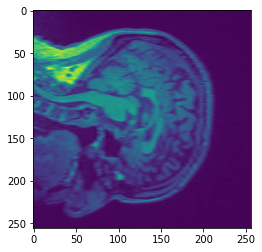

In [19]:
plt.imshow(lr_slice_upsampled)

In [20]:
#do fft 
hr_fft = np.fft.fftshift(np.fft.fftn(hr_sag_slice))
lr_fft = np.fft.fftshift(np.fft.fftn(lr_slice_upsampled))
sm_fft = np.fft.fftshift(np.fft.fftn(sm_sag_slice))



In [21]:
#plot in decibels
hr_db = fft_to_db(hr_fft)
lr_db = fft_to_db(lr_fft)
sm_db = fft_to_db(sm_fft)

In [22]:
vmin = -10
vmax = 128

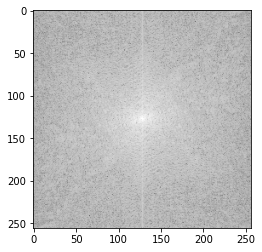

In [23]:
#visualize db plot
plt.imshow(np.rot90(hr_db),cmap="Greys_r",vmin=vmin,vmax=vmax)

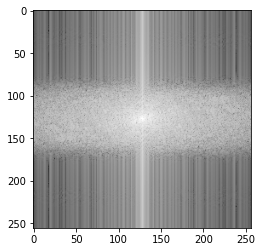

In [24]:
plt.imshow(np.rot90(lr_db),cmap="Greys_r",vmin=vmin,vmax=vmax)


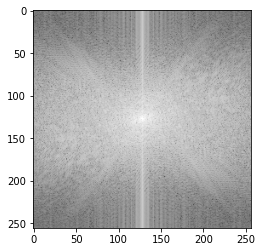

In [25]:
plt.imshow(np.rot90(sm_db),cmap="Greys_r",vmin=vmin,vmax=vmax)

In [215]:
#psnr
#error: tensorflow doesn't work for some reason,"Invalid reduction dimension (-3 for input with 2 dimension(s)"
#now using skimage


In [216]:
#compare psnr and ssim on whole brain volume
#resize lr_img
lr_rs_whole = resize(lr_img,dxyz=(1,1,1/ratio), order=3)

In [217]:
#whole ssim
ssim_w_lr = ssim(lr_rs_whole, hr_img, data_range = (hr_img.max()-hr_img.min())) #0.8654

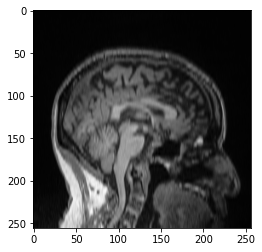

In [218]:
plt.imshow(np.rot90(lr_rs_whole[176//2]), cmap='Greys_r')

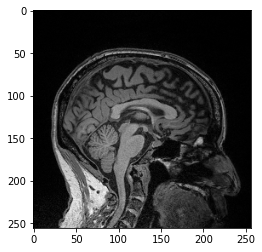

In [219]:
plt.imshow(np.rot90(hr_img[176//2]), cmap='Greys_r')

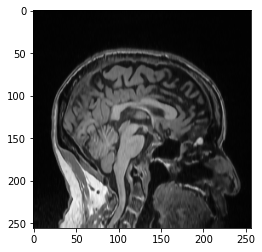

In [258]:
plt.imshow(np.rot90(sm_img[176//2]), cmap='Greys_r')

In [265]:
#whole psnr
#NOTE:skimage.metrics.peak_signal_noise_ratio: order does matter, og image comes first, then the output image
#bottom:27.15787, top:27.5071*

#29.0075114349545
psnr_w_lr = print_psnr(hr_img,lr_rs_whole)

30.83220774220036


In [266]:
ssim_w_lr = print_ssim(hr_img,lr_rs_whole)

0.9039241576400873


In [28]:
normalized_sm = normalize(sm_img,1.1*lr_img.max())

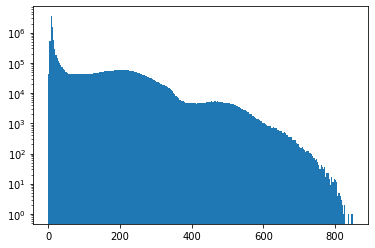

In [30]:
generate_histagram(normalized_sm)

In [32]:
psnr_w_sm = print_ssim(hr_img,normalized_sm)

0.8703245453037921


In [33]:
import copy

def calculate_magnitude(x_db,lr_dim):
    cent = x_db[3*(lr_dim//2):5*(lr_dim//2), 3*(lr_dim//2):5*(lr_dim//2)]
    cent_pwr = cent.sum()
    
    temp = copy.deepcopy(x_db)
    temp[lr_dim:3*lr_dim, lr_dim:3*lr_dim] = 0
    rim_pwr = temp.sum()
    return cent_pwr,rim_pwr

In [34]:
sm_center, sm_rim = calculate_magnitude(sm_db,64)
sm_center, sm_rim

(369742.5983934328, 3019885.546549958)

In [268]:
ssim_w_sm = print_ssim(hr_img,sm_img)

0.9343119240647035


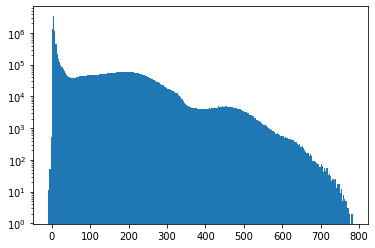

In [270]:
generate_histagram(lr_rs_whole)

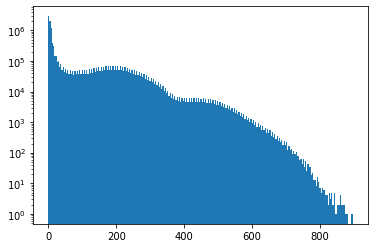

In [271]:
generate_histagram(hr_img)

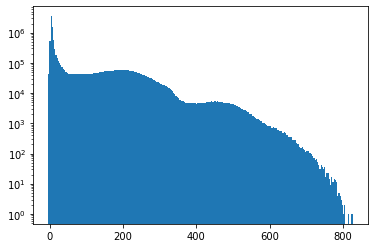

In [272]:
generate_histagram(sm_img)